<a href="https://colab.research.google.com/github/YagyanshB/tensorflow-freecodecamp/blob/main/keras_linear_estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing the required libraries

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# uploading the dataset in our environment

dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dftest = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_test = dftest.pop('survived')

# investigating the shape and features
print(dftrain.shape)
print(dftrain.columns)
print(dftrain.head())

# investigating for missing values
print(dftrain.isnull().sum())


(627, 9)
Index(['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck',
       'embark_town', 'alone'],
      dtype='object')
      sex   age  n_siblings_spouses  parch     fare  class     deck  \
0    male  22.0                   1      0   7.2500  Third  unknown   
1  female  38.0                   1      0  71.2833  First        C   
2  female  26.0                   0      0   7.9250  Third  unknown   
3  female  35.0                   1      0  53.1000  First        C   
4    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
sex                   0
age                   0
n_siblings_spouses    0
parch                 0
fare                  0
class                 0
deck                  0
embark_town           0
alone                 0
dtype: int64


In [4]:
def preprocess_titanic_data(train_df, test_df):
    # Create copies to avoid modifying originals
    train_proc = train_df.copy()
    test_proc = test_df.copy()

    # Check for any columns with string values like 'unknown'
    for col in train_proc.columns:
        # Replace 'unknown' with NaN so we can handle it properly
        if train_proc[col].dtype == object:
            train_proc[col] = train_proc[col].replace('unknown', np.nan)
            test_proc[col] = test_proc[col].replace('unknown', np.nan)

    # Handle categorical features
    # One-hot encode 'sex'
    train_proc['male'] = (train_df['sex'] == 'male').astype(float)
    test_proc['male'] = (test_df['sex'] == 'male').astype(float)

    # One-hot encode 'class' (assuming values like 'First', 'Second', 'Third')
    class_values = train_df['class'].unique()
    for cls in class_values:
        if pd.notna(cls): # Skip NaN values
            train_proc[f'class_{cls}'] = (train_df['class'] == cls).astype(float)
            test_proc[f'class_{cls}'] = (test_df['class'] == cls).astype(float)

    # One-hot encode 'embark_town'
    embark_values = train_df['embark_town'].unique()
    for embark in embark_values:
        if pd.notna(embark): # Skip NaN values
            train_proc[f'embark_{embark}'] = (train_df['embark_town'] == embark).astype(float)
            test_proc[f'embark_{embark}'] = (test_df['embark_town'] == embark).astype(float)

    # One-hot encode 'alone'
    train_proc['not_alone'] = (train_df['alone'] == False).astype(float)
    test_proc['not_alone'] = (test_df['alone'] == False).astype(float)

    # Drop original categorical columns
    train_proc = train_proc.drop(['sex', 'class', 'embark_town', 'alone'], axis=1)
    test_proc = test_proc.drop(['sex', 'class', 'embark_town', 'alone'], axis=1)

    # Fill missing numerical values with median
    for col in ['age', 'fare']:
        if col in train_proc.columns:
            median_val = train_df[col].median()
            train_proc[col] = train_proc[col].fillna(median_val)
            test_proc[col] = test_proc[col].fillna(median_val)

    # Check for remaining non-numeric columns and drop them if needed
    for col in train_proc.columns:
        if train_proc[col].dtype == object:
            print(f"Dropping non-numeric column: {col}")
            train_proc = train_proc.drop(col, axis=1)
            test_proc = test_proc.drop(col, axis=1)

    # Extract features and labels
    if 'survived' in train_proc.columns:
        X_train = train_proc.drop('survived', axis=1)
        y_train = train_proc['survived'].values.astype('float32')
    else:
        X_train = train_proc
        y_train = None

    if 'survived' in test_proc.columns:
        X_test = test_proc.drop('survived', axis=1)
        y_test = test_proc['survived'].values.astype('float32')
    else:
        X_test = test_proc
        y_test = None

    # Convert to numpy arrays
    X_train = X_train.values.astype('float32')
    X_test = X_test.values.astype('float32')

    return X_train, X_test, y_train, y_test

# Call the improved function
X_train, X_test, y_train_from_func, y_test_from_func = preprocess_titanic_data(dftrain, dftest)

# Use the y values we got from preprocessing, or the ones you already have if they're separate
if y_train_from_func is not None:
    y_train = y_train_from_func
else:
    y_train = y_train.values.astype('float32')  # Convert existing y_train to numpy array

if y_test_from_func is not None:
    y_test = y_test_from_func
else:
    y_test = y_test.values.astype('float32')    # Convert existing y_test to numpy array

Dropping non-numeric column: deck


In [5]:
# Create a linear model
model = tf.keras.Sequential([
    # Input layer with shape matching our features
    tf.keras.layers.Input(shape=(X_train.shape[1],)),

    # Linear classifier (a single dense layer with sigmoid activation)
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4136 - loss: 9.7993 - val_accuracy: 0.3788 - val_loss: 5.6892
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3498 - loss: 6.8128 - val_accuracy: 0.4280 - val_loss: 3.4172
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4601 - loss: 3.4772 - val_accuracy: 0.5114 - val_loss: 1.4522
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5570 - loss: 1.4865 - val_accuracy: 0.7083 - val_loss: 0.6450
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7112 - loss: 0.6449 - val_accuracy: 0.7538 - val_loss: 0.6119
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7100 - loss: 0.5901 - val_accuracy: 0.7424 - val_loss: 0.5841
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7374 - loss: 0.5546 - val_accuracy: 0.7614 - val_loss: 0.5683
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7634 - loss: 0.5267 - val_accuracy: 0.7652 - val_loss

In [6]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Make predictions
predictions = model.predict(X_test)
predicted_classes = (predictions > 0.5).astype(int).flatten()

# View some predictions
for i in range(10):
    print(f"Example {i+1}: True: {int(y_test[i])}, Predicted: {predicted_classes[i]}, Probability: {predictions[i][0]:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7924 - loss: 0.5150 
Test accuracy: 0.7765
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Example 1: True: 0, Predicted: 0, Probability: 0.1070
Example 2: True: 0, Predicted: 0, Probability: 0.2720
Example 3: True: 1, Predicted: 1, Probability: 0.6559
Example 4: True: 1, Predicted: 1, Probability: 0.6088
Example 5: True: 1, Predicted: 0, Probability: 0.2271
Example 6: True: 1, Predicted: 1, Probability: 0.5364
Example 7: True: 0, Predicted: 0, Probability: 0.3549
Example 8: True: 0, Predicted: 0, Probability: 0.1136
Example 9: True: 0, Predicted: 0, Probability: 0.3478
Example 10: True: 1, Predicted: 1, Probability: 0.5314


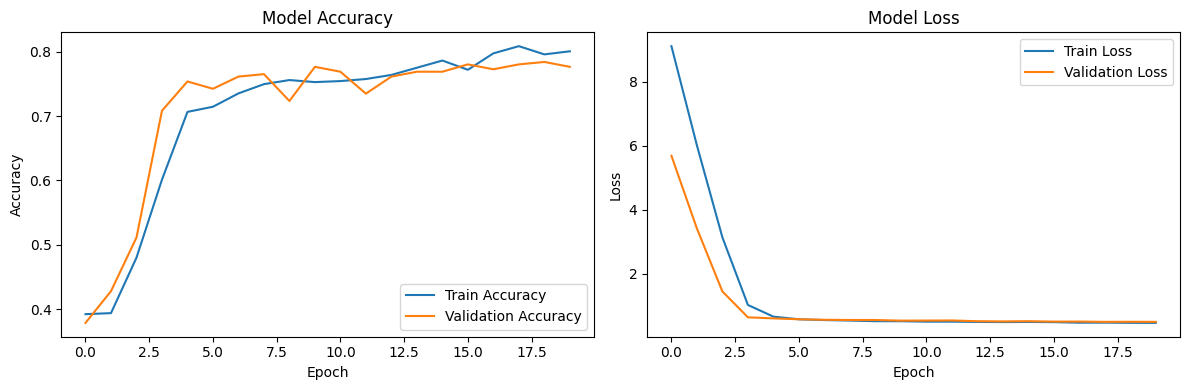

In [7]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()